In [1]:
import warnings
warnings.filterwarnings("ignore")
import glob
import torch
import time
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import torch.utils.data
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score, confusion_matrix
from torchvision import models
from IPython.display import clear_output

In [2]:
import sys
sys.path.append("../pyfiles/")
from util import image_from_output, cuda2numpy, cuda2cpu, weights_init, plot_confusion_matrix, min_max
from dataset import Dataset_mel

In [3]:
from PIL import Image

# Introduction
---
The aim of this notebook is to train an inception model which is used as a feature extractor for the FID score.

---

# CelebA Dataset
---
In this experiment, I'm gonna use two sound datasets: [RAVDESS](https://www.kaggle.com/uwrfkaggler/ravdess-emotional-speech-audio) and [TESS](https://www.kaggle.com/ejlok1/toronto-emotional-speech-set-tess). These are detailed in `A_preprocessing_TESS_and_RAVDESS.ipynb`.

I won't explain all the functions or models in this notebook, so, please visit `pyfiles/` for further information.

---
### Preparation
---
At first, I defined some valuables for dataset.

---

In [4]:
###############################################
############ adjustable parameters ############

emotions = ["neutral", "happy", "sad", "angry"] # the labels of classes
classes = tuple(range(len(emotions))) # classes tuple
target_length = 2**15 # data length, about 1.5 seconds
fs = 22050 # samling rate
root_TESS = "../../dataset/TESS/preprocessed/" # root path of the TESS dataset
root_RAVDESS = "../../dataset/RAVDESS/preprocessed/" # root path of the RAVDESS dataset

###############################################
###############################################

---
### Preprocessing
---
Firstly, The image in the dataset is random-cropped in a time scale to be the shape (80, 160) and then resized to be the shape (299, 299). When it comes to the value of the image, it's normalized to a range of [0, 1] followed by normalization using mean=[0.485,0.456,0.406] and std=[0.229,0.224,0.225], being separated with each channel.


---

In [8]:
transform = transforms.Compose([
    RandomCrop(),
    ToPIL(),
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

---
Let's have a look at some samples of the dataset.

---

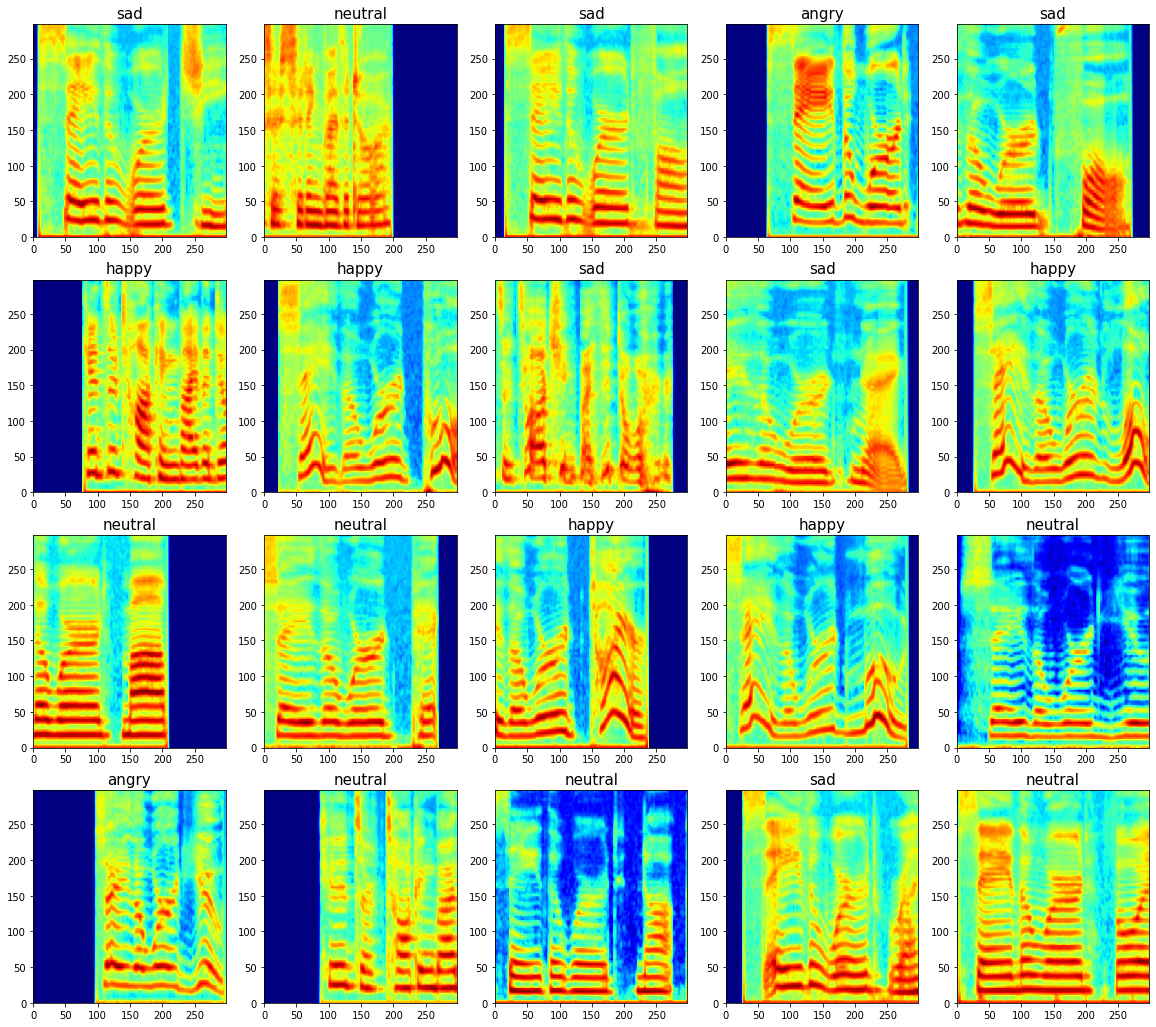

In [9]:
width = 5
length = 4
dataset = Dataset_mel(root_TESS, root_RAVDESS, transform, emotions, target_length, mode="all", dataset="both", additional_transformer=False)
fig = plt.figure(figsize=(4*width, 4.5*length))
for i in range(width*length):
    index = np.random.randint(0,len(dataset))
    data = dataset[index]
    img = data[0]
    M = img[0]
    title = emotions[data[1]]
    plot_spectrogram(M, fig, (length, width, i+1), title=title)
#     plt.axis('off')
# plt.subplots_adjust(wspace=0.01, hspace=0.03)

# Training
---
Let's train the classifier.

---
### Preparation
---
To observe the accuracy while training, firstly the fuction for test process is defined below.

---

In [10]:
def do_test(net, testloader, device="cuda", mode="eval"):
    if mode=="train":
        net.train()
    elif mode=="eval":
        net.eval()
    else:
        return None
    labels = np.array([])
    with torch.no_grad():
        for itr, data in enumerate(testloader):
            images = data[0].to(device)
            label = cuda2numpy(data[1])
            output = cuda2numpy(net(images))
            if itr==0:
                outputs = output
            else:
                outputs = np.concatenate([outputs, output], axis=0)
            labels = np.append(labels, label)
    return labels, outputs

---
At first, let's define some parameters for the architecture of the classifier.

---

In [11]:
epoch_num = 301 # the number of epochs
lr = 0.001 # initial learning rate
save_parameter = True # do you wanna save parameters ?
test_interval = 3 # the interval among validation check

In [12]:
# torch.cuda.set_device("cuda:4")
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

---
Then, let's call the classifier and the algorithms for training.

---

In [16]:
devices = [0,1,2,3]
net = torch.hub.load('pytorch/vision:v0.5.0', 'inception_v3', pretrained=False)
net.fc = nn.Linear(in_features=2048, out_features=len(classes))
net.aux_logits = False
net = net.to(device)
net.apply(weights_init)
net = nn.DataParallel(net, devices)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)

Using cache found in /opt/.cache/torch/hub/pytorch_vision_v0.5.0


---
Then, call the training and the validation dataset.

---

In [17]:
###############################################
############ adjustable parameters ############

train_batch = 128
val_batch = 128

###############################################
###############################################

dataset = Dataset_mel(root_TESS, root_RAVDESS, transform, emotions, target_length, mode="train", dataset="both", additional_transformer=False)
dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=train_batch, shuffle=True)

valset = Dataset_mel(root_TESS, root_RAVDESS, transform, emotions, target_length, mode="val", dataset="both", additional_transformer=False)
valloader = torch.utils.data.DataLoader(dataset=valset, batch_size=val_batch, shuffle=True)
len(dataset), len(valset)

(2000, 232)

---
Let's train your model. The model's accuracy is being tested every 3 epochs with the validation dataset.

---

300
test acc in 300 : 0.9267241379310345
best acc is   : 0.9353448275862069 in epoch105


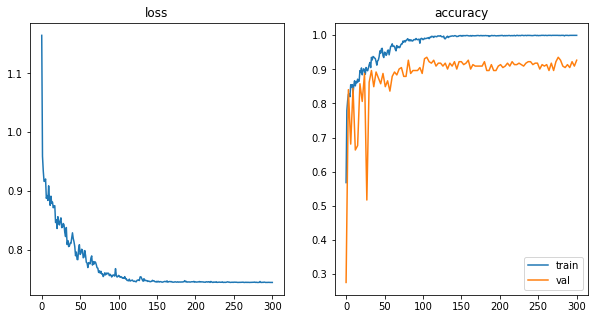

In [18]:
net.train()
losses_epoch = []
acc_epoch = []
acc_test_list = []
best_epoch = 0
best_acc = 0
for epoch in range(epoch_num):
    losses = []
    accs = []
    for itr, data in enumerate(dataloader):
        net.train()
        x = data[0].to(device)
        label = data[1].to(device)
        optimizer.zero_grad()
        y = F.softmax(net(x))
        loss = criterion(y, label)
        loss.backward()
        optimizer.step()
        loss = cuda2numpy(loss)
        label = cuda2numpy(label)
        y = cuda2numpy(y)
        acc = (np.argmax(y, axis=1) == label).sum().item()/len(label)
        losses.append(loss)
        accs.append(acc)
    scheduler.step()
    losses_epoch.append(np.mean(np.array(losses)))
    acc_epoch.append(np.mean(np.array(accs)))
    if epoch%test_interval==0:
        labels, outputs = do_test(net, valloader, device, "eval")
        pred_labels = np.argmax(outputs, axis=1) 
        acc_test = accuracy_score(labels, pred_labels)
        acc_test_list.append(acc_test)
        if best_acc < acc_test:
            best_acc = acc_test
            best_epoch = epoch
            
    clear_output(wait=True)
    print(epoch)
    print(f"test acc in {epoch//test_interval*test_interval} : {acc_test}")
    print(f"best acc is   : {best_acc} in epoch{best_epoch}")
    
    if save_parameter:
        if epoch%test_interval==0:
            torch.save(net.module.state_dict(), f"./instant_model_parameter/mel_emotion_classifier_inception_lr{lr}_epoch{epoch}.pth")
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(1,2,1)
    ax.plot(losses_epoch)
    ax.set_title("loss")
    ax = fig.add_subplot(1,2,2)
    ax.plot(acc_epoch, label="train")
    ax.plot(np.arange(epoch//test_interval+1)*test_interval, acc_test_list, label="val")
    ax.legend()
    ax.set_title('accuracy')
    plt.show()

---
You can load the well-trained model with the code below.

---

In [16]:
# ----- adjustable parameters ----- #
load_epoch = 204
# --------------------------------- #

net = torch.hub.load('pytorch/vision:v0.5.0', 'inception_v3', pretrained=False)
net.fc = nn.Linear(in_features=2048, out_features=len(classes))
net.aux_logits = False
net = net.to(device)

load_parameter = True
# dir = "../data/parameters/B/"
dir = "../instant_model_parameter/"
model_path = f"{dir}mel_emotion_classifier_inception_lr0.001_epoch{load_epoch}.pth"
if load_parameter:
    model = torch.load(model_path, map_location=device) 
    net.load_state_dict(model)

Using cache found in /opt/.cache/torch/hub/pytorch_vision_v0.5.0


---
This is the test dataset. Of course, this is separated from the training and the validation dataset.

---

In [17]:
###############################################
############ adjustable parameters ############

test_batch = 128

###############################################
###############################################

testset = Dataset_mel(root_TESS, root_RAVDESS, transform, emotions, target_length, mode="test", dataset="both", additional_transformer=False)
testloader = torch.utils.data.DataLoader(dataset=testset, batch_size=train_batch, shuffle=True)
len(testset)

232

---
Evaluate it many times.

---

In [18]:
# ----- adjustable parameters ----- #
test_num = 10
# --------------------------------- #

acc_list = []
cm_list = []
for i in range(test_num):
    print(i)
    labels, outputs = do_test(net, testloader, device, "eval")
    pred_labels = np.argmax(outputs, axis=1) 
    acc_test = accuracy_score(labels, pred_labels)
    acc_list.append(acc_test)
    cm = confusion_matrix(labels, pred_labels, labels=np.arange(len(classes)))
    cm_list.append(cm)
    clear_output(wait=True)
print(f"test acc is : {np.mean(acc_list)}")

test acc is : 0.8918103448275861


---
Check the detail (confusion matrix)

---

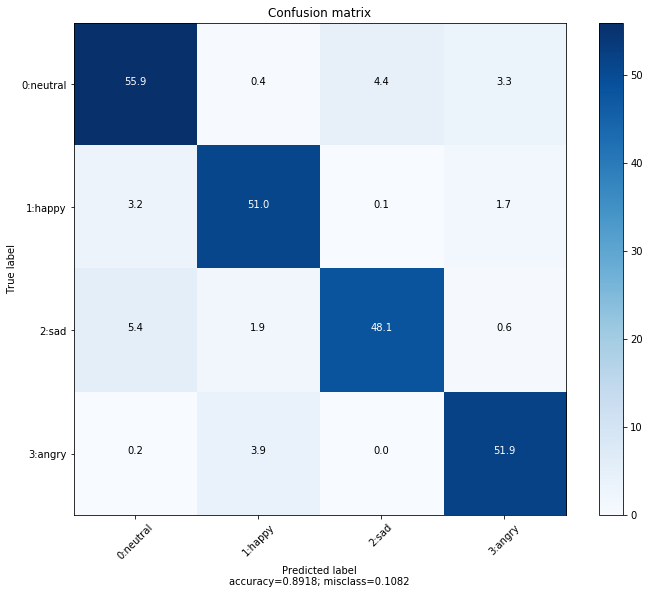

In [19]:
class_idx_lbl = emotions.copy()
for i in range(len(emotions)):
    class_idx_lbl[i] = f"{i}:{emotions[i]}"
        
cm = np.mean(np.array(cm_list), axis=0)
plot_confusion_matrix(cm, class_idx_lbl, normalize=False)

## Misclassification
---
It's also essential to observe the mis-classification in order to improve your model or to find some flaws of the model.

---


the samples of 'happy' which are classified as 'angry''



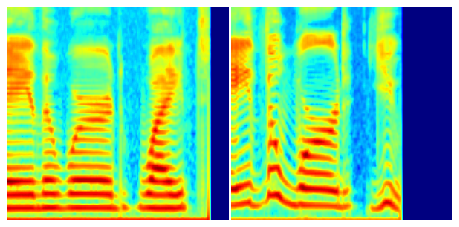

In [20]:
# ----- adjustable parameters ----- #
true_class = 1
misclassified_class = 3
width = 5
length = 4
# --------------------------------- #
print("")
print(f"the samples of '{emotions[true_class]}' which are classified as '{emotions[misclassified_class]}''")
print("")
fig = plt.figure(figsize=(4*width, 4*length))
miss_index_list = np.arange(len(labels))[np.array(np.array(pred_labels==misclassified_class, dtype=np.int) * np.array(labels==true_class, dtype=np.int), dtype=np.bool)]
for i in range(len(miss_index_list[:width*length])):
    x, _ = testset[miss_index_list[i]]
    M = x[0]
    #title = emotions[data[1]]
    plot_spectrogram(M, fig, (length, width, i+1), title="")
    plt.axis('off')
plt.subplots_adjust(wspace=0.01, hspace=0.03)

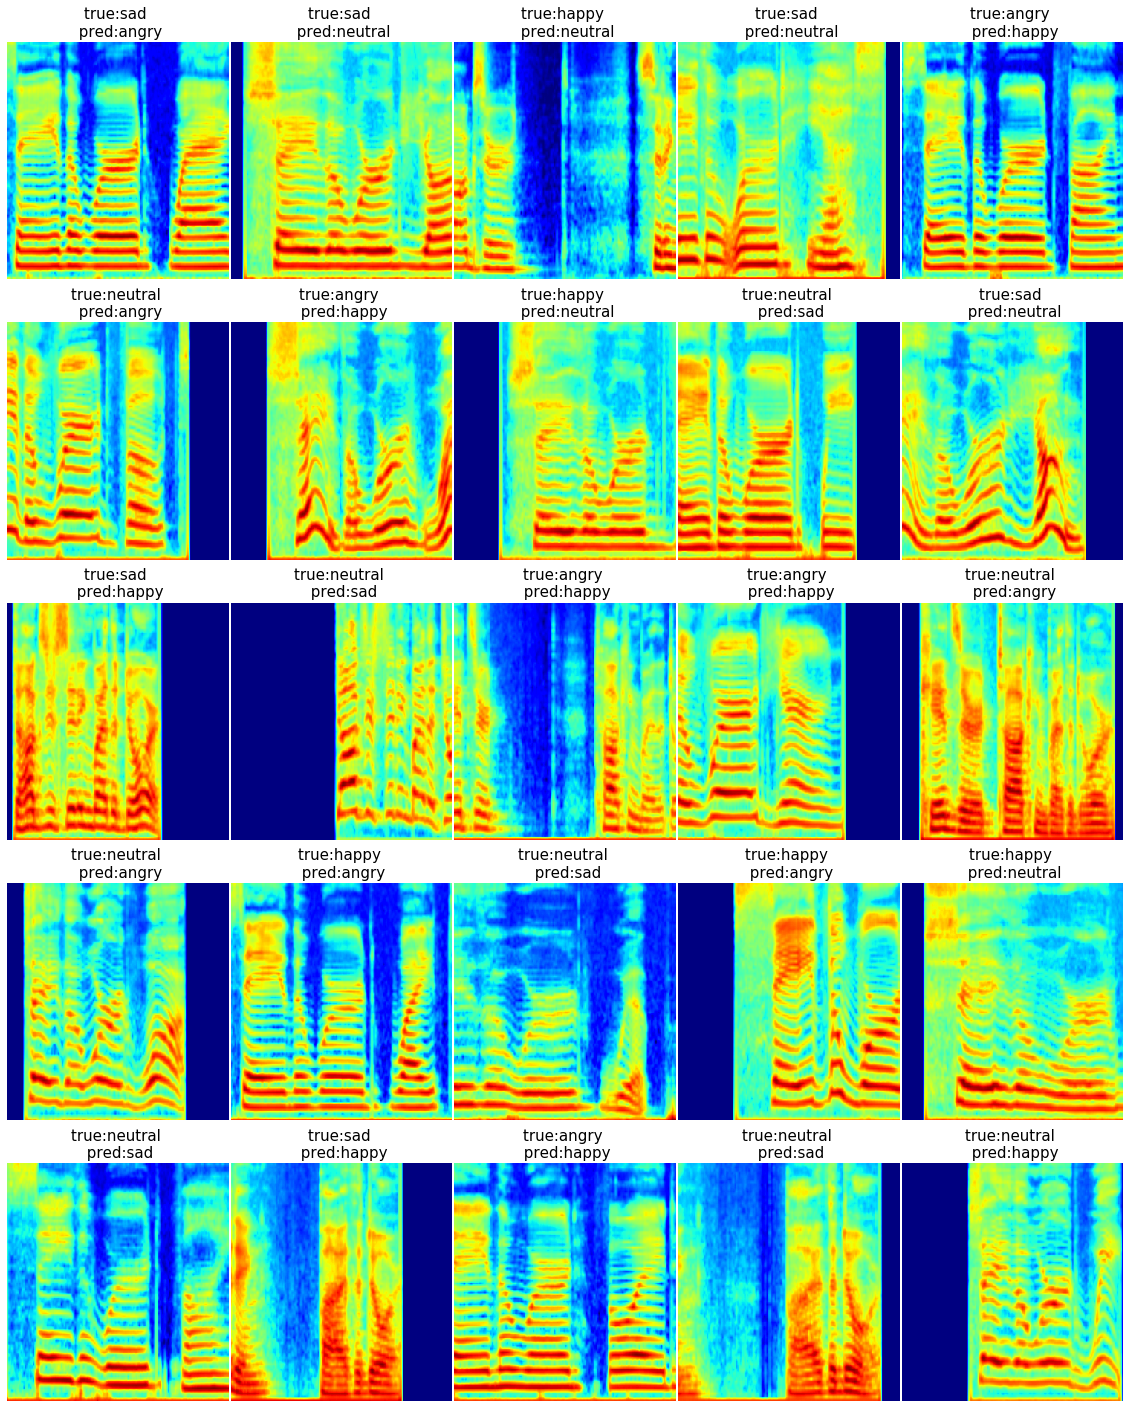

In [21]:
# ----- adjustable parameters ----- #
width = 5
length = 5
# --------------------------------- #

index_bool = pred_labels!=labels
indexes = np.random.choice(np.arange(len(labels))[index_bool], size=min(width*length,index_bool.sum()), replace=False)

fig = plt.figure(figsize=(4*width, 5*length))
for i in range(len(indexes)):
    idx = indexes[i]
    x, _ = testset[idx]
    M = x[0]
    title = f"true:{emotions[int(labels[idx])]} \n pred:{emotions[pred_labels[idx]]}"
    plot_spectrogram(M, fig, (length, width, i+1), title=title)
    plt.axis('off')
plt.subplots_adjust(wspace=0.01, hspace=0.18)